In [47]:
# Re-load the dataset after execution state reset
import pandas as pd
import warnings
warnings.filterwarnings("ignore")

file_path = "Project1 Data.csv"
df = pd.read_csv(file_path)



In [48]:
# Convert 'Date' column to datetime format
df['Date'] = pd.to_datetime(df['Date'], errors='coerce')

# Identify the first and last available date for each index
date_ranges = {}
for col in df.columns[1:]:  # Exclude 'Date' column
    available_dates = df[df[col].notna()]['Date']
    if not available_dates.empty:
        date_ranges[col] = (available_dates.min(), available_dates.max())

# Convert to DataFrame for display
date_ranges_df = pd.DataFrame.from_dict(date_ranges, orient='index', columns=['Start Date', 'End Date'])



In [49]:
date_ranges_df.to_clipboard()

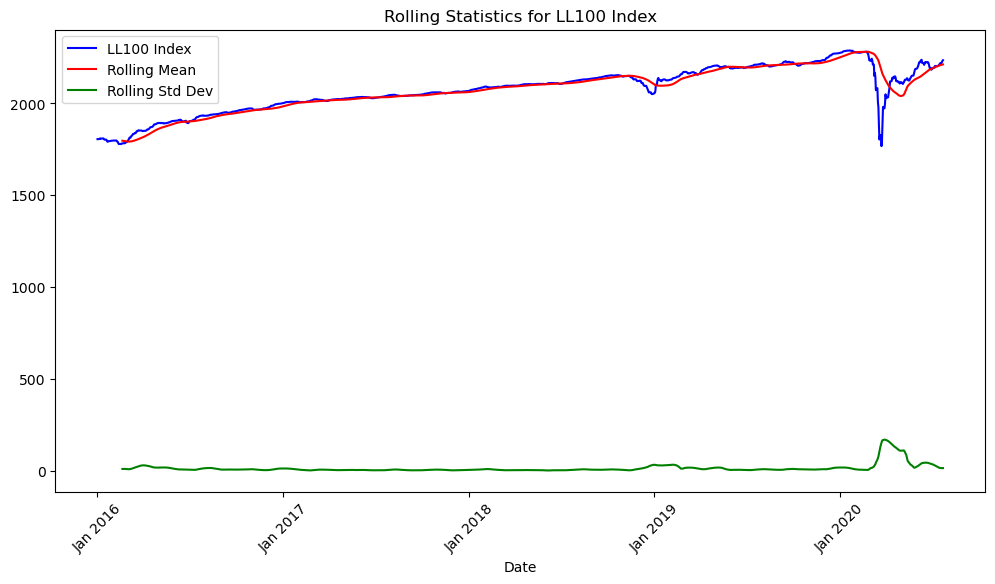


========= ADF Test Results =========
Test Statistic: -2.0957383120446686
p-value: 0.24623169716206822
Critical Values:
  1%: -3.4343485210432236
  5%: -2.863306117083598
  10%: -2.5677102410843804

========= KPSS Test Results =========
Test Statistic: 5.222266712557361
p-value: 0.01
Critical Values:
  10%: 0.347
  5%: 0.463
  2.5%: 0.574
  1%: 0.739

========= Ljung-Box Test Results =========
     lb_stat  lb_pvalue
10 1.583e+04  0.000e+00

========= Phillips-Perron (PP) Test Results: =========
Test Statistic: -2.0957383120446686
p-value: 0.24623169716206822
Critical Values:
  1%: -3.4343485210432236
  5%: -2.863306117083598
  10%: -2.5677102410843804


In [50]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller, kpss
from statsmodels.stats.diagnostic import acorr_ljungbox

# Load dataset
file_path = "Project1 Data.csv"  # Update with your file path if needed
df = pd.read_csv(file_path, parse_dates=['Date'])
# Convert Date column to datetime
df['Date'] = pd.to_datetime(df['Date'])


# Select LL100 index and drop missing values
ll100_series = df['LL100'].dropna()

# Initialize a dictionary to store test results
test_results = {}

# ========== 1. Augmented Dickey-Fuller (ADF) Test ==========
adf_result = adfuller(ll100_series)
adf_statistic, adf_pvalue, _, _, adf_critical_values, _ = adf_result

test_results["ADF Test"] = {
    "Test Statistic": adf_statistic,
    "p-value": adf_pvalue,
    "Critical Values": adf_critical_values
}

# ========== 2. Kwiatkowski-Phillips-Schmidt-Shin (KPSS) Test ==========
kpss_statistic, kpss_pvalue, _, kpss_critical_values = kpss(ll100_series, regression="c", nlags="auto")

test_results["KPSS Test"] = {
    "Test Statistic": kpss_statistic,
    "p-value": kpss_pvalue,
    "Critical Values": kpss_critical_values
}

# ========== 3. Ljung-Box Test (Autocorrelation Check) ==========
ljung_box_results = acorr_ljungbox(ll100_series, lags=[10], return_df=True)

test_results["Ljung-Box Test"] = ljung_box_results


# Perform the Phillips-Perron (PP) Test
pp_result = adfuller(ll100_series, regression='c', autolag='AIC')

# Extract test statistic, p-value, and critical values
pp_statistic, pp_pvalue, _, _, pp_critical_values, _ = pp_result



# ========== Visualization of Rolling Statistics ==========



# Extract LL100 time series
ll100_series = df.set_index("Date")["LL100"].dropna()

# Compute rolling mean and standard deviation
rolling_mean = ll100_series.rolling(window=50).mean()
rolling_std = ll100_series.rolling(window=50).std()

# Plot the time series with formatted x-axis
plt.figure(figsize=(12, 6))
plt.plot(ll100_series, label="LL100 Index", color="blue")
plt.plot(rolling_mean, label="Rolling Mean", color="red")
plt.plot(rolling_std, label="Rolling Std Dev", color="green")

# Formatting x-axis to show month and year
plt.xlabel("Date")
plt.xticks(rotation=45)
plt.gca().xaxis.set_major_formatter(plt.matplotlib.dates.DateFormatter("%b %Y"))

plt.title("Rolling Statistics for LL100 Index")
plt.legend()
plt.show()

# Display results
print("\n========= ADF Test Results =========")
print(f"Test Statistic: {test_results['ADF Test']['Test Statistic']}")
print(f"p-value: {test_results['ADF Test']['p-value']}")
print("Critical Values:")
for key, value in test_results['ADF Test']['Critical Values'].items():
    print(f"  {key}: {value}")

print("\n========= KPSS Test Results =========")
print(f"Test Statistic: {test_results['KPSS Test']['Test Statistic']}")
print(f"p-value: {test_results['KPSS Test']['p-value']}")
print("Critical Values:")
for key, value in test_results['KPSS Test']['Critical Values'].items():
    print(f"  {key}: {value}")

print("\n========= Ljung-Box Test Results =========")
print(ljung_box_results)

# Print results
print("\n========= Phillips-Perron (PP) Test Results: =========")
print(f"Test Statistic: {pp_statistic}")
print(f"p-value: {pp_pvalue}")
print("Critical Values:")
for key, value in pp_critical_values.items():
    print(f"  {key}: {value}")


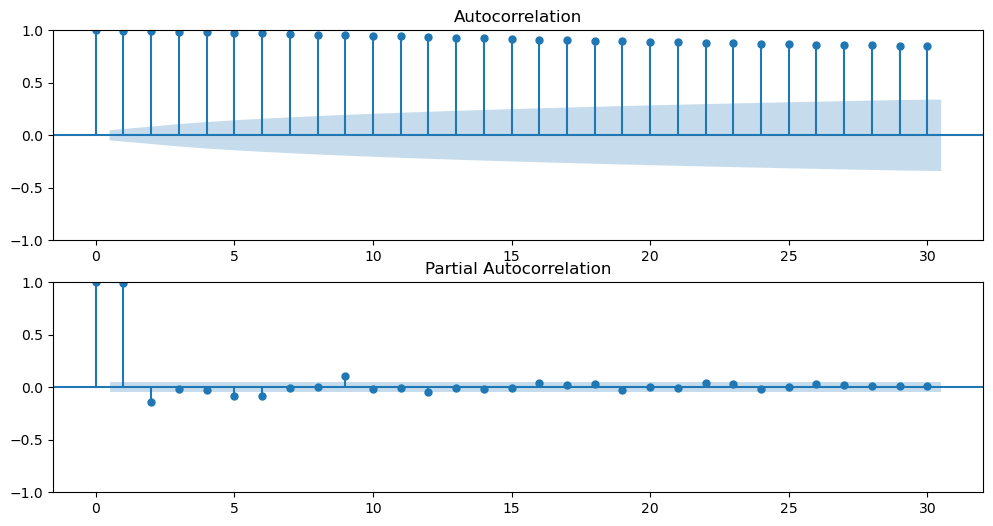

In [51]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

plt.figure(figsize=(12, 6))
plt.subplot(2, 1, 1)
plot_acf(ll100_series, lags=30, ax=plt.gca())  # ACF Plot

plt.subplot(2, 1, 2)
plot_pacf(ll100_series, lags=30, ax=plt.gca())  # PACF Plot

plt.show()


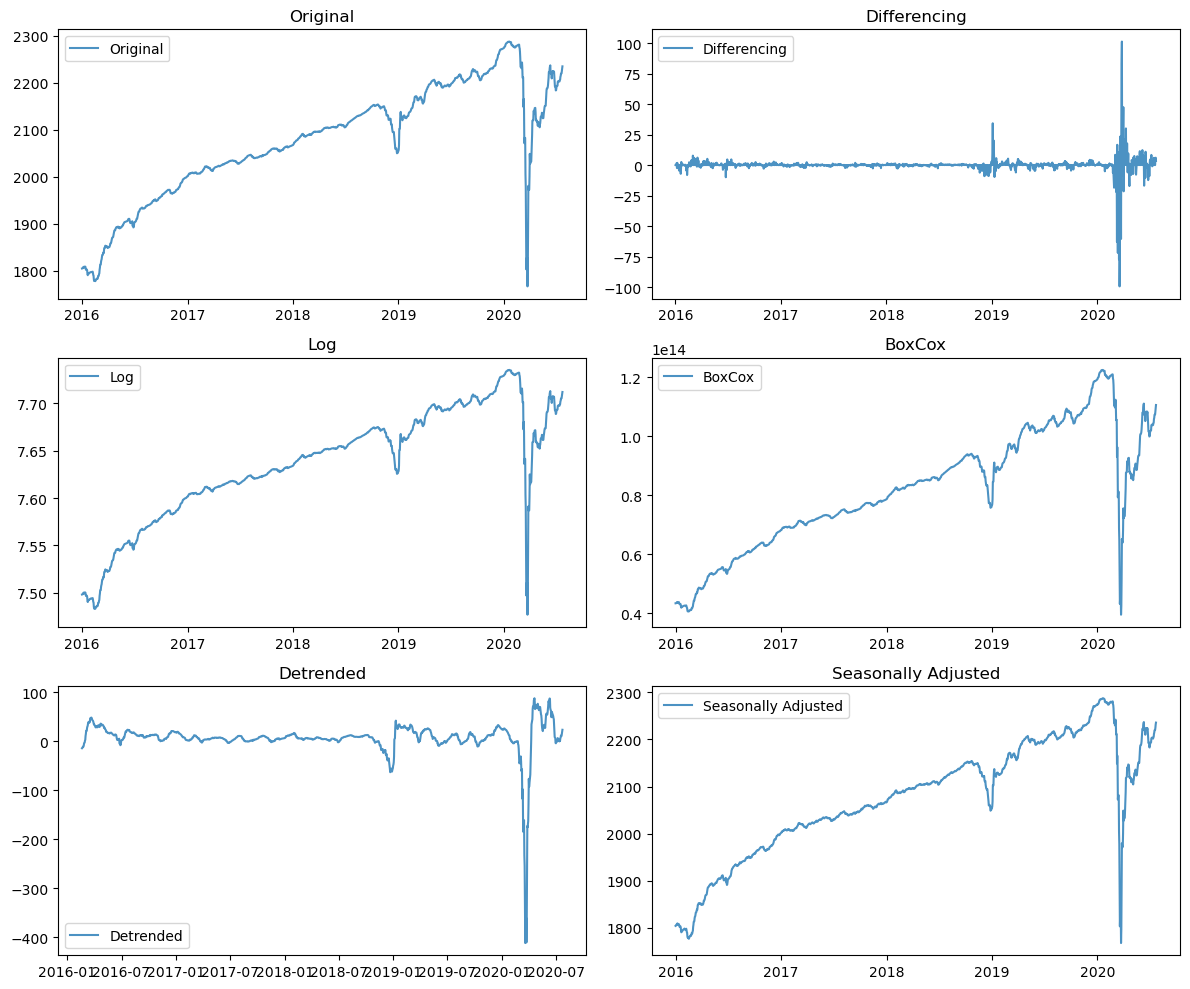

In [52]:
from statsmodels.tsa.seasonal import seasonal_decompose
from scipy.stats import boxcox

# Ensure LL100 series is positive for Box-Cox transformation
ll100_positive = ll100_series[ll100_series > 0]

# Apply transformations again with proper handling
df_transformed = pd.DataFrame(index=ll100_series.index)
df_transformed["Original"] = ll100_series

# 1. First-Order Differencing
df_transformed["Differencing"] = ll100_series.diff()

# 2. Log Transformation (Only for positive values)
df_transformed["Log"] = np.log(ll100_positive)

# 3. Box-Cox Transformation (Only for positive values)
df_transformed.loc[ll100_positive.index, "BoxCox"], lambda_val = boxcox(ll100_positive)

# 4. Moving Average Detrending
rolling_mean = ll100_series.rolling(window=50).mean()
df_transformed["Detrended"] = ll100_series - rolling_mean

# 5. Seasonal Adjustment
seasonal_decomp = seasonal_decompose(ll100_series, model="additive", period=12)
df_transformed["Seasonally Adjusted"] = ll100_series - seasonal_decomp.seasonal

# Run ADF test on each transformation
adf_results = {}
for col in df_transformed.columns:
    transformed_series = df_transformed[col].dropna()
    if not transformed_series.empty:
        adf_test = adfuller(transformed_series)
        adf_results[col] = {"ADF Statistic": adf_test[0], "p-value": adf_test[1]}

# Convert ADF results to a DataFrame
adf_results_df = pd.DataFrame.from_dict(adf_results, orient="index")

# Plot all transformations
plt.figure(figsize=(12, 10))
for i, col in enumerate(df_transformed.columns, 1):
    plt.subplot(3, 2, i)
    plt.plot(df_transformed[col], label=col, alpha=0.8)
    plt.title(col)
    plt.legend()
plt.tight_layout()
plt.show()



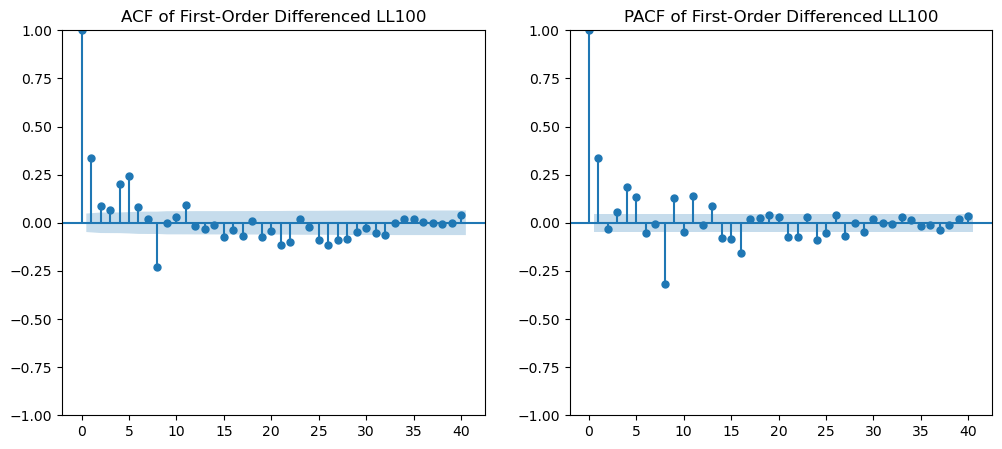

In [53]:


# Extract LL100 time series and drop NaN values
ll100_series = df.set_index("Date")["LL100"].dropna()

# Apply first-order differencing
ll100_diff = ll100_series.diff().dropna()

# Plot ACF and PACF
fig, ax = plt.subplots(1, 2, figsize=(12, 5))
sm.graphics.tsa.plot_acf(ll100_diff, lags=40, ax=ax[0])
ax[0].set_title("ACF of First-Order Differenced LL100")
sm.graphics.tsa.plot_pacf(ll100_diff, lags=40, ax=ax[1])
ax[1].set_title("PACF of First-Order Differenced LL100")
plt.show()


In [54]:

adf_results_df

,ADF Statistic,p-value
Original,-2.096e+00,2.462e-01
Differencing,-9.413e+00,5.768e-16
Log,-2.209e+00,2.029e-01
BoxCox,-1.791e+00,3.849e-01
Detrended,-5.800e+00,4.654e-07
Seasonally Adjusted,-2.088e+00,2.493e-01


### Cut off from start date to end date

In [55]:
from statsmodels.tsa.stattools import grangercausalitytests
import numpy as np

# Determine the common time period where all indices have data
common_start_date = max(date_ranges_df["Start Date"])
common_end_date = min(date_ranges_df["End Date"])

# Filter the dataset for this period
df_filtered = df[(df["Date"] >= common_start_date) & (df["Date"] <= common_end_date)].copy()

# Drop rows with any missing values in this restricted period
df_filtered.dropna(inplace=True)

# Perform Granger causality tests between LL100 and all other indices
lag_max = 5  # Maximum lags to consider

# Store results
granger_results = {}

for col in df_filtered.columns[1:]:  # Exclude 'Date'
    if col != "LL100":
        test_result = grangercausalitytests(df_filtered[[col,"LL100"]], lag_max, verbose=False)
        p_values = [test_result[i][0]['ssr_chi2test'][1] for i in range(1, lag_max + 1)]
        # min_p_value = min(p_values)
        granger_results[col] = p_values

# Convert results to a DataFrame for better readability
granger_results_df = pd.DataFrame.from_dict(granger_results, orient="index", columns=[f"Lag {i}" for i in range(1, lag_max + 1)])
# Apply scientific notation with 3 decimal places to the entire DataFrame
pd.options.display.float_format = '{:.3e}'.format

# Alternatively, if applied to a specific DataFrame:
granger_results_df = granger_results_df.applymap(lambda x: f"{x:.3e}" if isinstance(x, float) else x)
# granger_results_df.sort_values(by="Min P-Value", inplace=True)
granger_results_df



,Lag 1,Lag 2,Lag 3,Lag 4,Lag 5
PRME,7.771e-01,4.837e-01,4.331e-03,2.359e-05,3.282e-08
INDU,9.345e-01,6.563e-01,1.679e-10,3.070e-14,9.863e-14
CONS,4.362e-02,4.033e-02,9.058e-10,1.368e-16,3.834e-19
ENRS,2.536e-02,7.857e-02,1.028e-06,1.751e-06,4.980e-06
HLTH,1.662e-04,1.156e-03,8.048e-11,7.830e-14,7.143e-16
INFT,3.472e-04,3.002e-05,1.747e-13,1.196e-18,1.225e-19
UTIL,1.932e-03,1.759e-02,4.751e-21,2.913e-25,4.298e-29
TELS,3.564e-01,4.917e-02,1.994e-08,1.305e-14,3.501e-15
FINA,7.088e-01,6.767e-01,2.225e-08,2.993e-12,3.022e-12
EE,6.681e-01,2.513e-01,6.643e-11,2.021e-12,9.803e-12


In [56]:
granger_results = {}

for col in df_filtered.columns[1:]:  # Exclude 'Date'
    if col != "LL100":
        test_result = grangercausalitytests(df_filtered[["LL100",col]], lag_max, verbose=False)
        p_values = [test_result[i][0]['ssr_chi2test'][1] for i in range(1, lag_max + 1)]
        # min_p_value = min(p_values)
        granger_results[col] = p_values

# Convert results to a DataFrame for better readability
granger_results_df = pd.DataFrame.from_dict(granger_results, orient="index", columns=[f"Lag {i}" for i in range(1, lag_max + 1)])
granger_results_df = granger_results_df.applymap(lambda x: f"{x:.3e}" if isinstance(x, float) else x)
granger_results_df

,Lag 1,Lag 2,Lag 3,Lag 4,Lag 5
PRME,2.563e-01,6.610e-01,1.770e-02,6.577e-05,1.465e-04
INDU,2.930e-11,4.061e-12,5.650e-02,9.120e-02,1.242e-01
CONS,2.378e-02,5.422e-24,4.028e-05,2.378e-07,6.058e-08
ENRS,4.707e-39,3.360e-16,4.013e-05,1.746e-02,7.814e-03
HLTH,8.052e-06,1.317e-14,1.149e-02,1.023e-03,2.499e-04
INFT,5.816e-22,2.740e-26,3.915e-05,1.476e-04,6.624e-05
UTIL,5.981e-06,1.082e-26,6.499e-07,8.708e-12,3.107e-13
TELS,1.269e-02,6.218e-09,4.877e-01,7.342e-03,1.201e-02
FINA,4.173e-03,1.046e-13,1.441e-01,4.960e-02,6.745e-02
EE,8.326e-04,2.330e-07,3.179e-01,4.757e-01,5.593e-01


In [57]:
granger_results_df.to_clipboard()

### Normalize the series

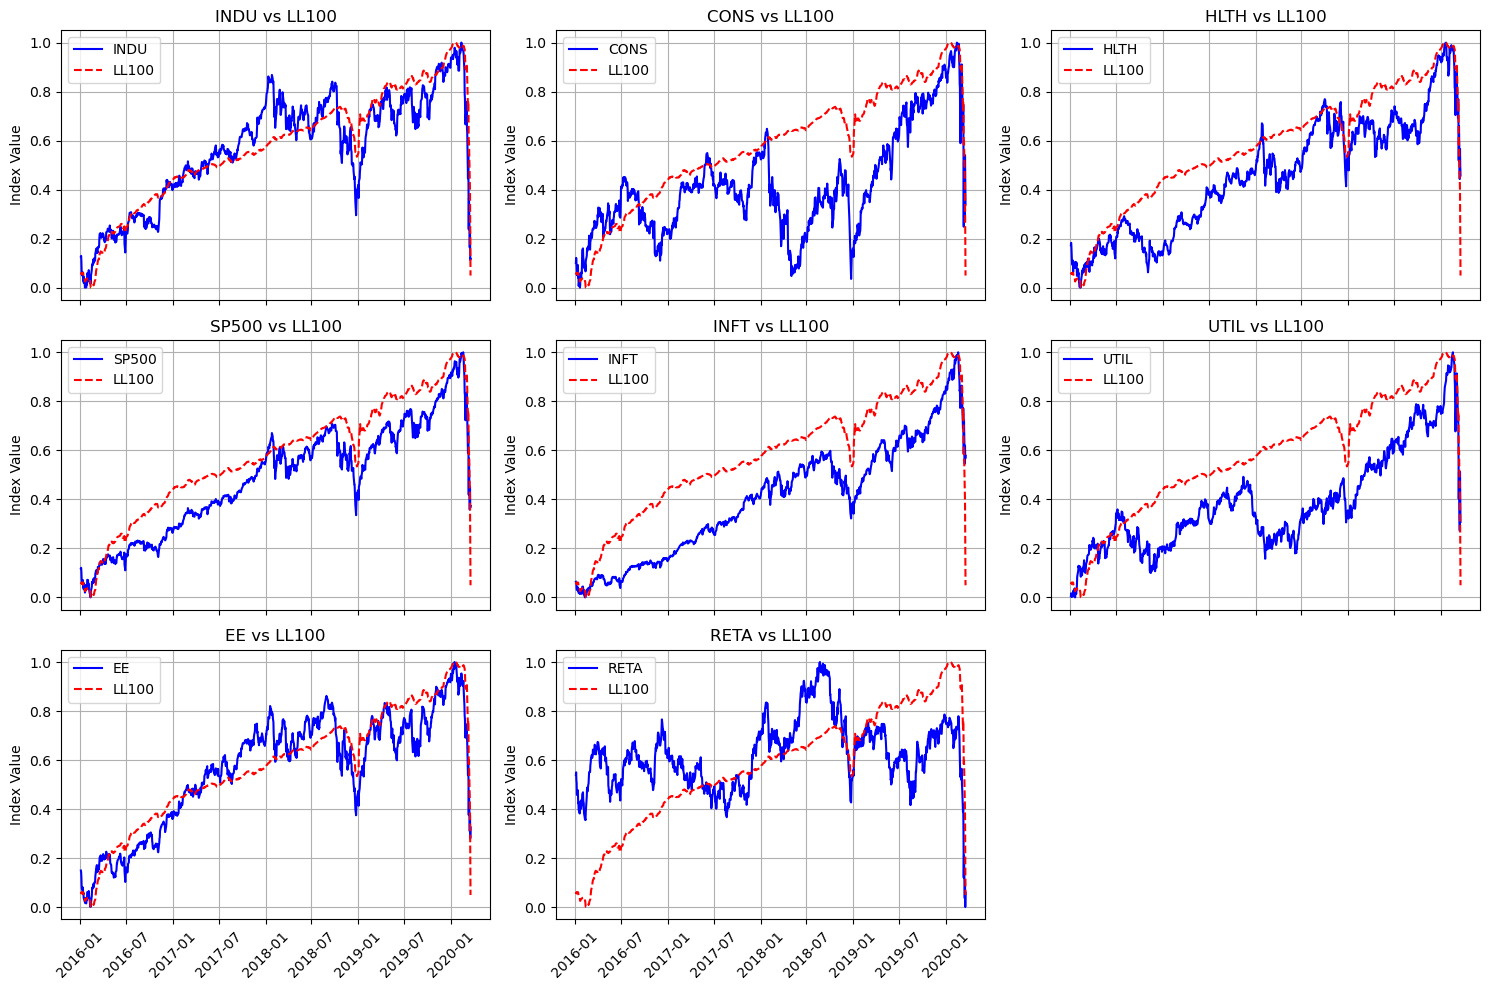

In [58]:
import matplotlib.pyplot as plt

def normalize_series(series):
    return (series - series.min()) / (series.max() - series.min())
# Indices with strong Granger causality relationships to LL100
strong_leading_indices = ["INDU", "CONS", "HLTH", "SP500", "INFT","UTIL","EE","RETA"]

df_normalized = df_filtered.copy()
df_normalized["LL100"] = normalize_series(df_normalized["LL100"])

for index in strong_leading_indices:
    df_normalized[index] = normalize_series(df_filtered[index])
# Create subplots for all leading indices vs LL100
fig, axes = plt.subplots(3, 3, figsize=(15, 10), sharex=True)

# Flatten axes array for easier indexing
axes = axes.flatten()

for i, index in enumerate(strong_leading_indices):
    axes[i].plot(df_normalized["Date"], df_normalized[index], label=index, color='blue')
    axes[i].plot(df_normalized["Date"], df_normalized["LL100"], label="LL100", color='red', linestyle="dashed")
    axes[i].set_ylabel("Index Value")
    axes[i].set_title(f"{index} vs LL100")
    axes[i].legend()
    axes[i].grid()

    axes[i].tick_params(axis="x", rotation=45) 
fig.delaxes(axes[-1])
axes[-1].set_xlabel("Date")
plt.tight_layout()
plt.show()


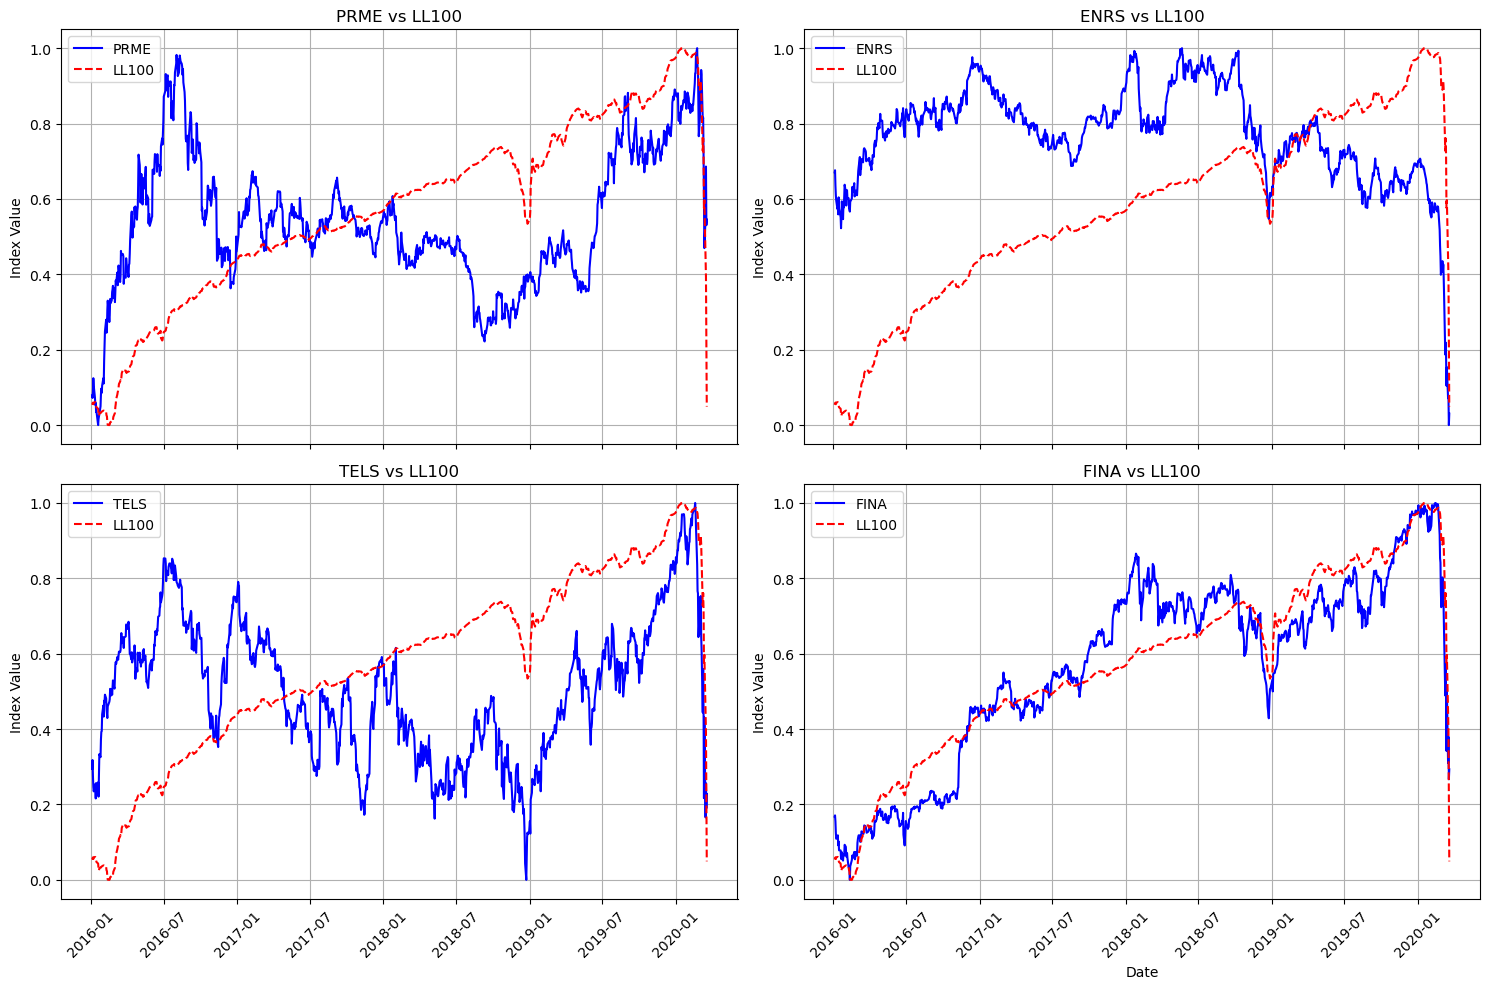

In [59]:
other_indices = ["PRME","ENRS","TELS","FINA"]
for index in other_indices:
    df_normalized[index] = normalize_series(df_filtered[index])

fig, axes = plt.subplots(2, 2, figsize=(15, 10), sharex=True)
# Flatten axes array for easier indexing
axes = axes.flatten()

for i, index in enumerate(other_indices):
    axes[i].plot(df_normalized["Date"], df_normalized[index], label=index, color='blue')
    axes[i].plot(df_normalized["Date"], df_normalized["LL100"], label="LL100", color='red', linestyle="dashed")
    axes[i].set_ylabel("Index Value")
    axes[i].set_title(f"{index} vs LL100")
    axes[i].legend()
    axes[i].grid()
    axes[i].tick_params(axis="x", rotation=45) 

axes[-1].set_xlabel("Date")
plt.tight_layout()
plt.show()

### Zoom in to see the detail, Normalize each one to see the trend


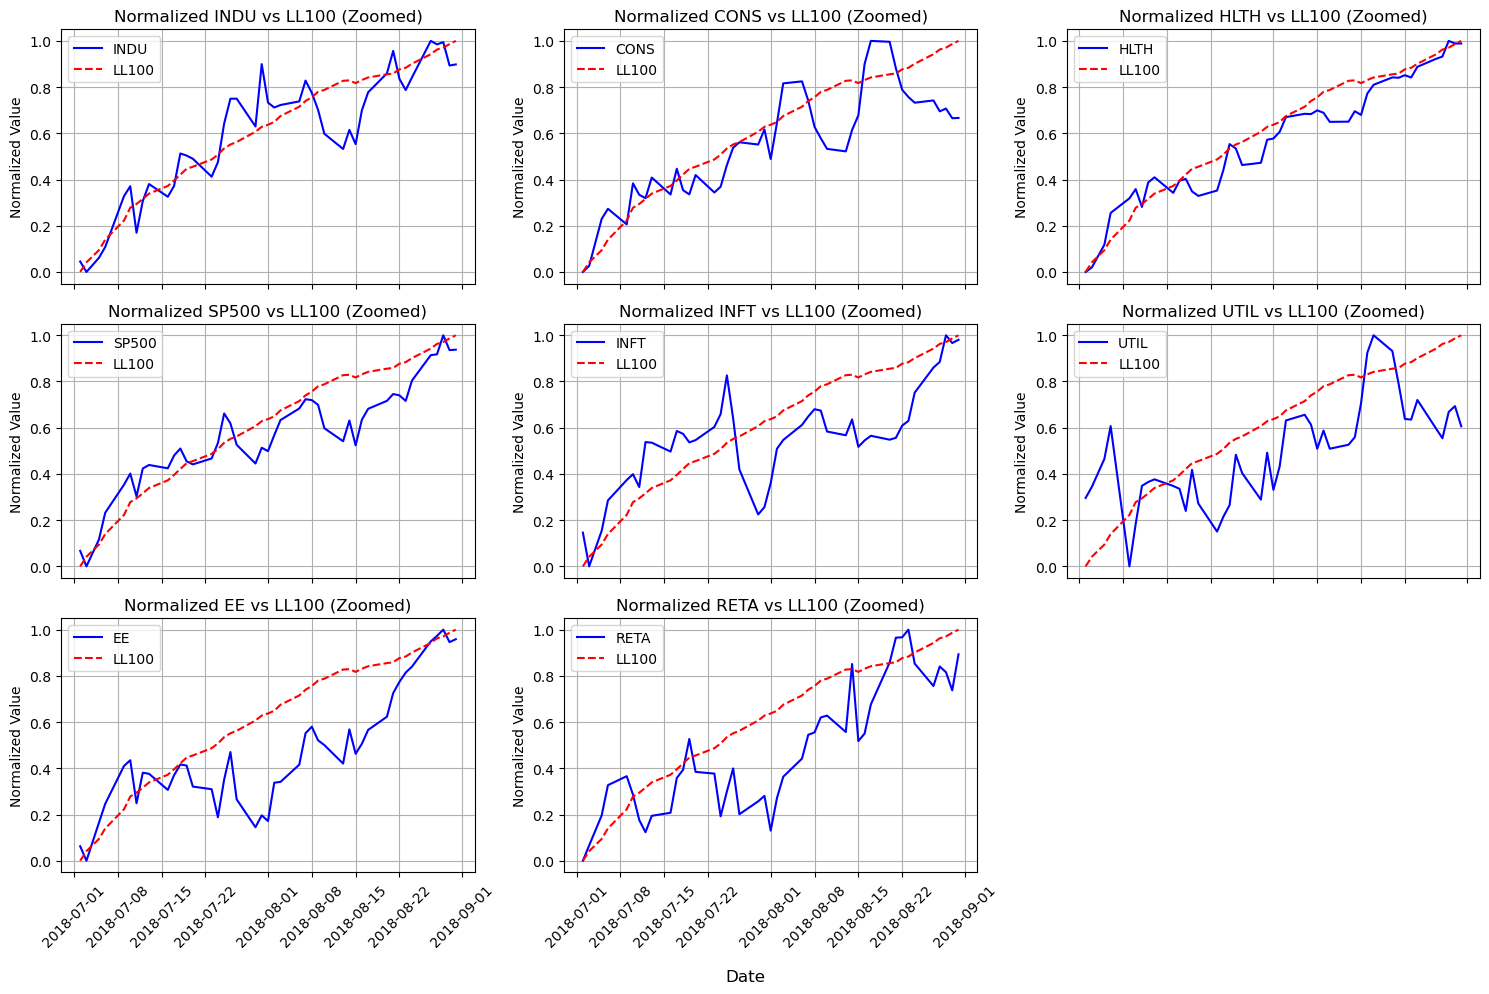

In [60]:
# Define a zoomed-in time range (mid-2018 to early 2019)
zoom_start_date = "2018-07-01"
zoom_end_date = "2018-09-01"

# Filter dataset for the zoomed-in period
df_zoomed = df_filtered[(df_filtered["Date"] >= zoom_start_date) & (df_filtered["Date"] <= zoom_end_date)]



# Normalize LL100 and all selected indices within the zoomed-in range
df_zoomed_normalized = df_zoomed.copy()
df_zoomed_normalized["LL100"] = normalize_series(df_zoomed["LL100"])

for index in strong_leading_indices:
    df_zoomed_normalized[index] = normalize_series(df_zoomed[index])

# Create a 2x3 subplot layout with normalized values for better overlay
fig, axes = plt.subplots(3, 3, figsize=(15, 10), sharex=True)

# Flatten axes array for easier indexing
axes = axes.flatten()

# Plot each leading index normalized
for i, index in enumerate(strong_leading_indices):
    axes[i].plot(df_zoomed_normalized["Date"], df_zoomed_normalized[index], label=index, color='blue')
    axes[i].plot(df_zoomed_normalized["Date"], df_zoomed_normalized["LL100"], label="LL100", color='red', linestyle="dashed")
    axes[i].set_ylabel("Normalized Value")
    axes[i].set_title(f"Normalized {index} vs LL100 (Zoomed)")
    axes[i].legend()
    axes[i].grid()
    
    # Improve x-axis formatting
    axes[i].tick_params(axis="x", rotation=45)

# Hide the last empty subplot
fig.delaxes(axes[-1])

# Set common x-axis label and adjust layout
fig.supxlabel("Date")
plt.tight_layout()
plt.show()


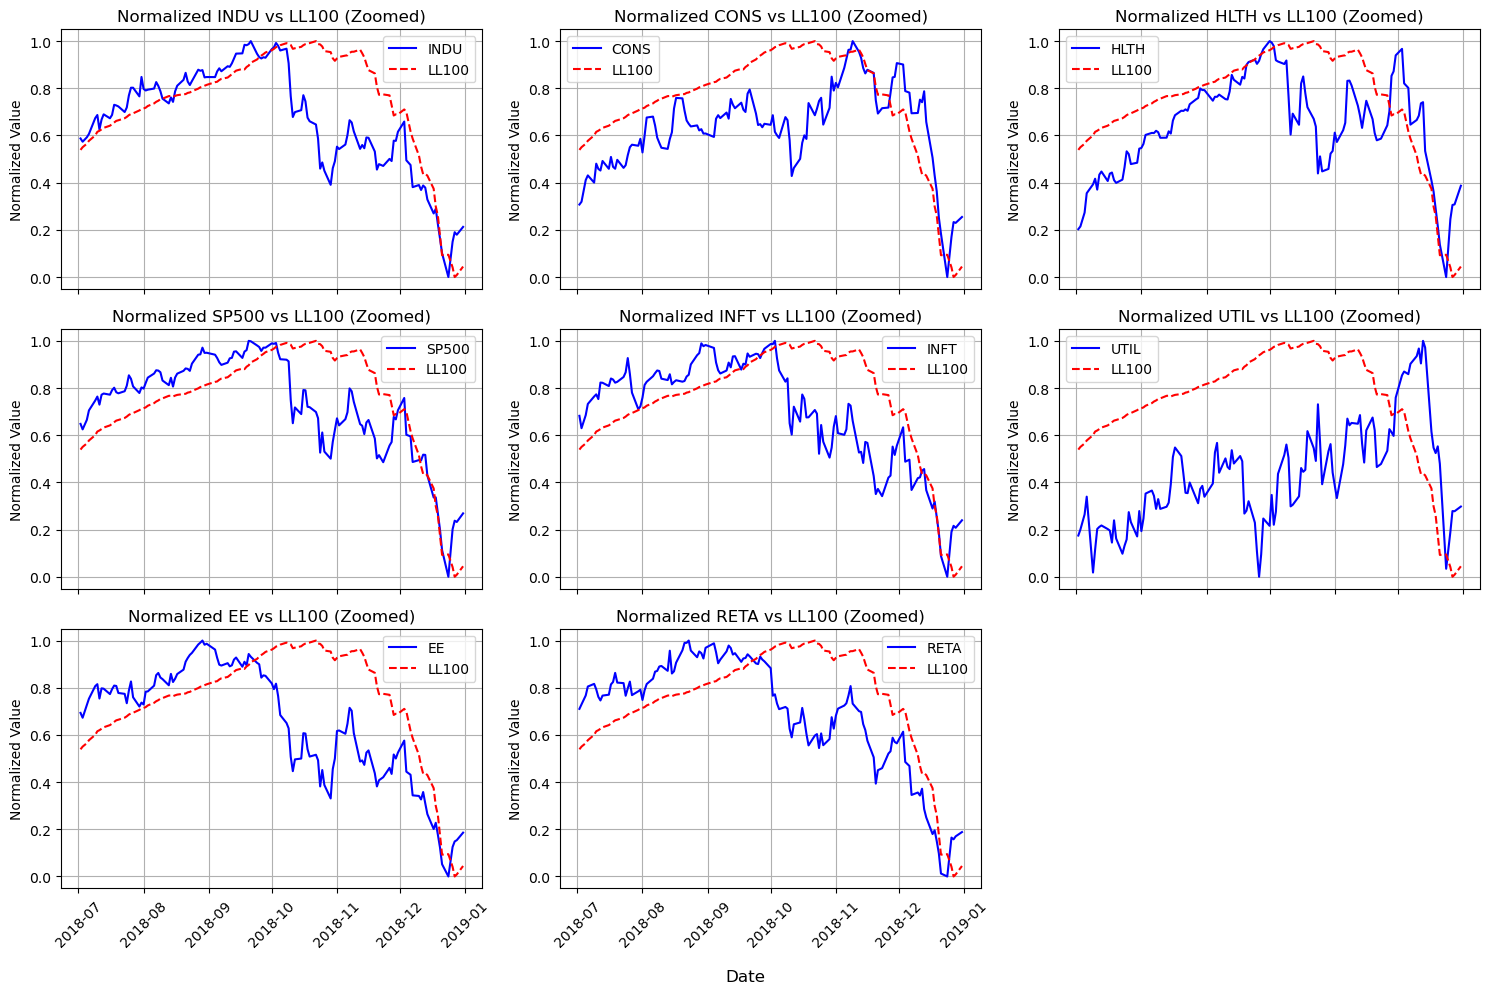

In [61]:
# Define a zoomed-in time range (mid-2018 to early 2019)
zoom_start_date = "2018-07-01"
zoom_end_date = "2019-01-01"

# Filter dataset for the zoomed-in period
df_zoomed = df_filtered[(df_filtered["Date"] >= zoom_start_date) & (df_filtered["Date"] <= zoom_end_date)]

# Normalize the indices and LL100 for better overlay comparison
def normalize_series(series):
    return (series - series.min()) / (series.max() - series.min())

# Normalize LL100 and all selected indices within the zoomed-in range
df_zoomed_normalized = df_zoomed.copy()
df_zoomed_normalized["LL100"] = normalize_series(df_zoomed["LL100"])

for index in strong_leading_indices:
    df_zoomed_normalized[index] = normalize_series(df_zoomed[index])

# Create a 2x3 subplot layout with normalized values for better overlay
fig, axes = plt.subplots(3, 3, figsize=(15, 10), sharex=True)

# Flatten axes array for easier indexing
axes = axes.flatten()

# Plot each leading index normalized
for i, index in enumerate(strong_leading_indices):
    axes[i].plot(df_zoomed_normalized["Date"], df_zoomed_normalized[index], label=index, color='blue')
    axes[i].plot(df_zoomed_normalized["Date"], df_zoomed_normalized["LL100"], label="LL100", color='red', linestyle="dashed")
    axes[i].set_ylabel("Normalized Value")
    axes[i].set_title(f"Normalized {index} vs LL100 (Zoomed)")
    axes[i].legend()
    axes[i].grid()
    
    # Improve x-axis formatting
    axes[i].tick_params(axis="x", rotation=45)

# Hide the last empty subplot
fig.delaxes(axes[-1])

# Set common x-axis label and adjust layout
fig.supxlabel("Date")
plt.tight_layout()
plt.show()


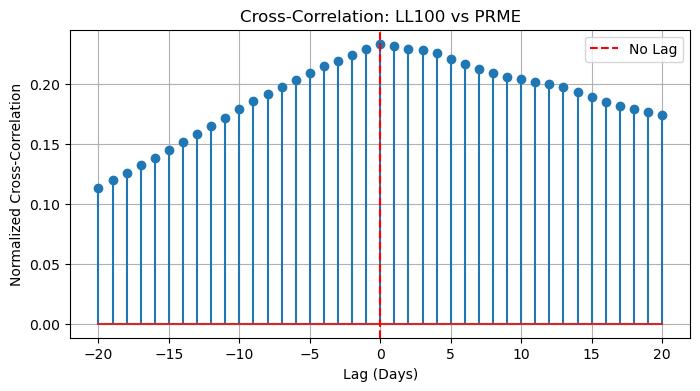

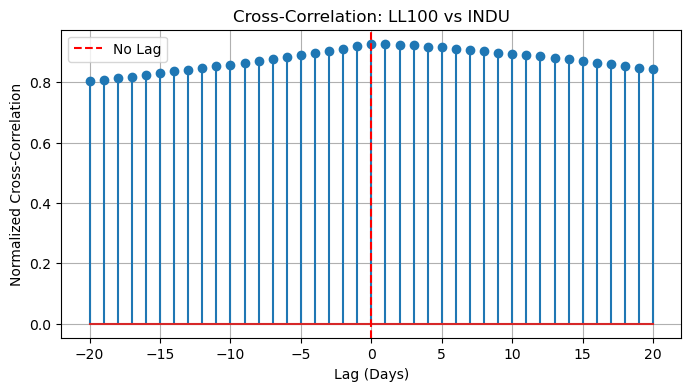

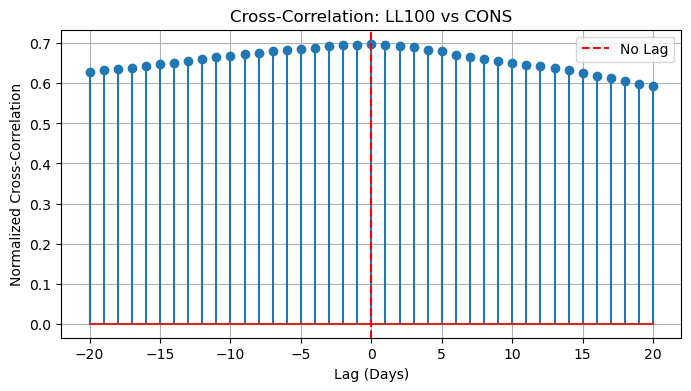

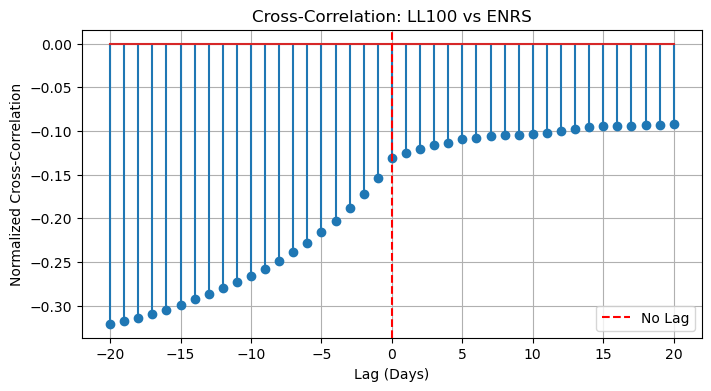

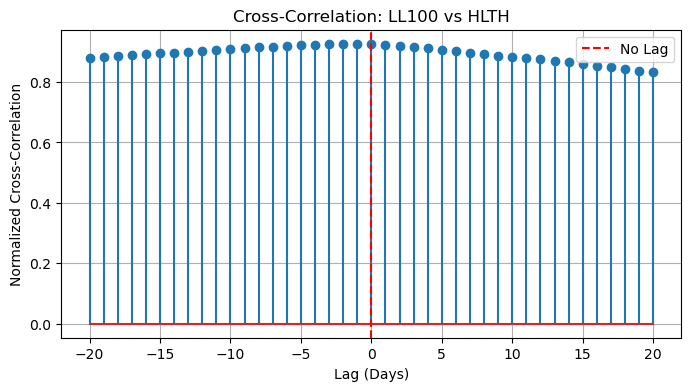

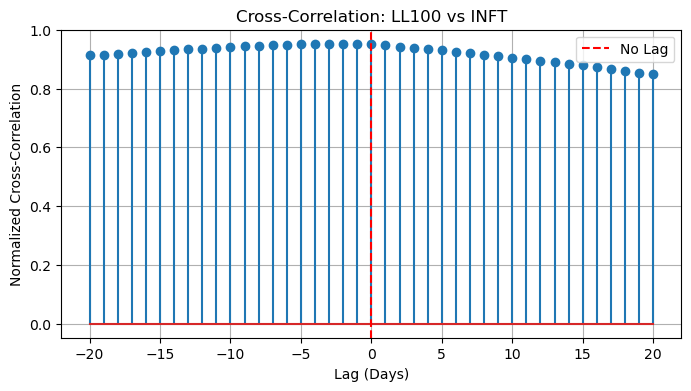

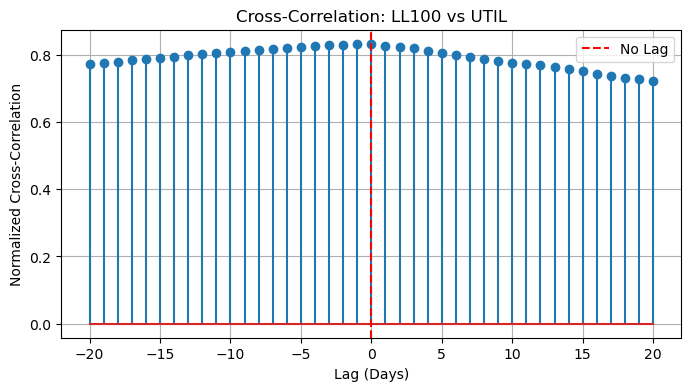

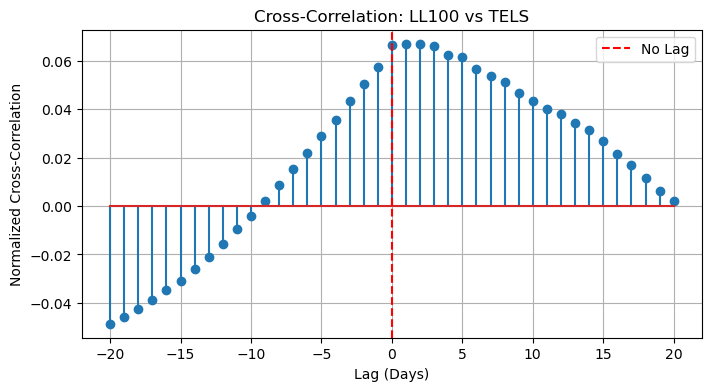

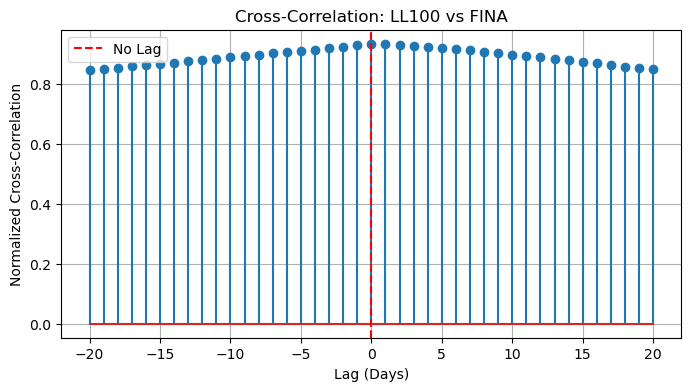

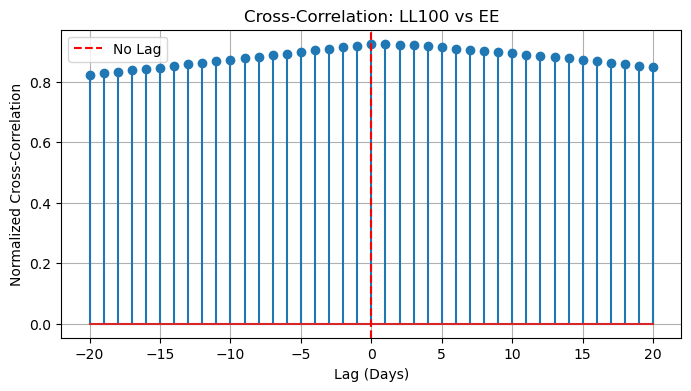

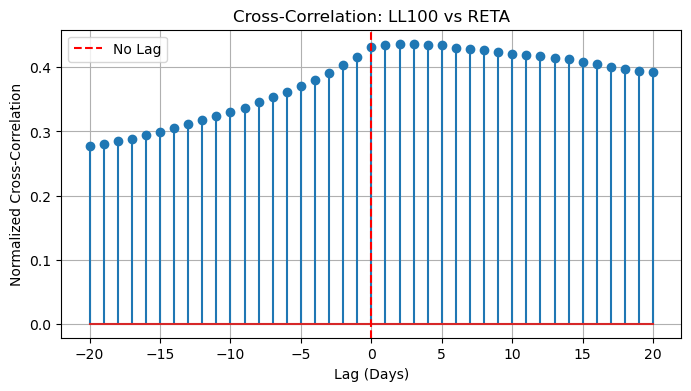

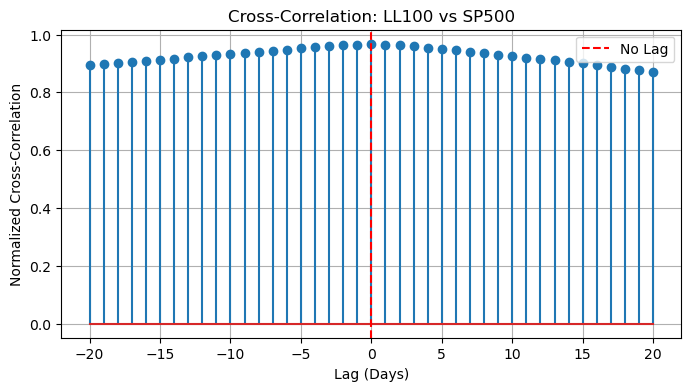

In [62]:
# Re-load the dataset and preprocess it again
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import correlate

# Load the dataset
file_path = "Project1 Data.csv"
df = pd.read_csv(file_path)

# Convert 'Date' column to datetime format
df['Date'] = pd.to_datetime(df['Date'], errors='coerce')

# Identify the first and last available date for each index
date_ranges = {}
for col in df.columns[1:]:  # Exclude 'Date' column
    available_dates = df[df[col].notna()]['Date']
    if not available_dates.empty:
        date_ranges[col] = (available_dates.min(), available_dates.max())

# Convert to DataFrame for filtering common period
date_ranges_df = pd.DataFrame.from_dict(date_ranges, orient='index', columns=['Start Date', 'End Date'])

# Determine the common time period where all indices have data
common_start_date = max(date_ranges_df["Start Date"])
common_end_date = min(date_ranges_df["End Date"])

# Filter the dataset for this period
df_filtered = df[(df["Date"] >= common_start_date) & (df["Date"] <= common_end_date)].copy()

# Drop rows with any missing values in this restricted period
df_filtered.dropna(inplace=True)

# Function to compute normalized cross-correlation
def normalized_cross_correlation(series1, series2, max_lag=20):
    series1 = (series1 - series1.mean()) / series1.std()
    series2 = (series2 - series2.mean()) / series2.std()
    
    # Compute cross-correlation
    corr = correlate(series1, series2, mode="full") / len(series1)
    lags = np.arange(-len(series1) + 1, len(series1))
    
    # Restrict to max_lag range
    mid = len(corr) // 2
    corr = corr[mid - max_lag : mid + max_lag + 1]
    lags = lags[mid - max_lag : mid + max_lag + 1]
    
    return lags, corr

# Generate cross-correlation plots for LL100 vs every other index
indices = [col for col in df_filtered.columns if col != "Date" and col != "LL100"]

for index in indices:
    lags, corr = normalized_cross_correlation(df_filtered["LL100"], df_filtered[index], max_lag=20)

    # Plot the cross-correlation
    plt.figure(figsize=(8, 4))
    plt.stem(lags, corr)
    plt.axvline(x=0, color='red', linestyle='--', label="No Lag")
    plt.xlabel("Lag (Days)")
    plt.ylabel("Normalized Cross-Correlation")
    plt.title(f"Cross-Correlation: LL100 vs {index}")
    plt.legend()
    plt.grid()
    plt.show()


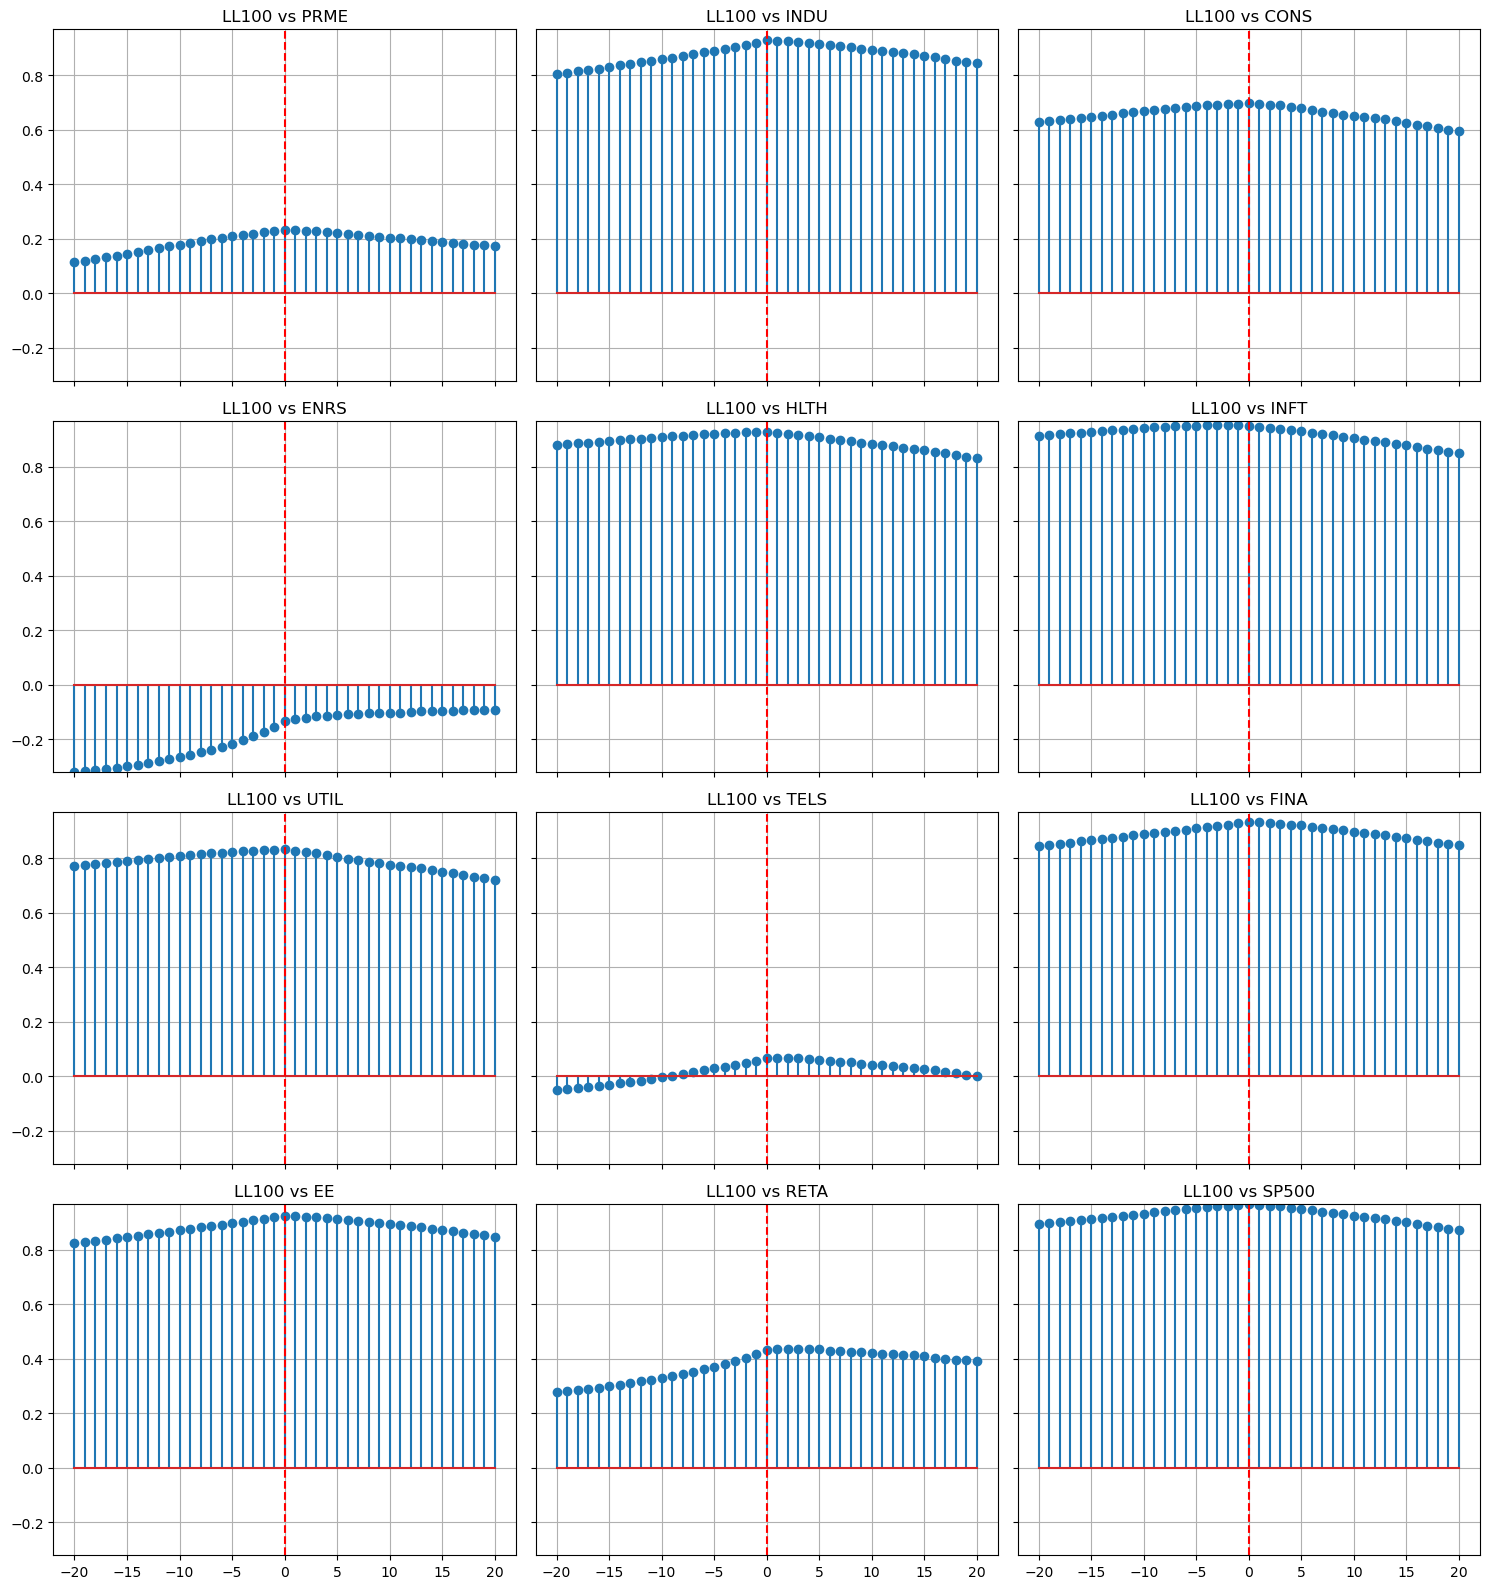

In [63]:
# Re-load the dataset and preprocess it again
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import correlate

# Load the dataset
file_path = "Project1 Data.csv"
df = pd.read_csv(file_path)

# Convert 'Date' column to datetime format
df['Date'] = pd.to_datetime(df['Date'], errors='coerce')

# Identify the first and last available date for each index
date_ranges = {}
for col in df.columns[1:]:  # Exclude 'Date' column
    available_dates = df[df[col].notna()]['Date']
    if not available_dates.empty:
        date_ranges[col] = (available_dates.min(), available_dates.max())

# Convert to DataFrame for filtering common period
date_ranges_df = pd.DataFrame.from_dict(date_ranges, orient='index', columns=['Start Date', 'End Date'])

# Determine the common time period where all indices have data
common_start_date = max(date_ranges_df["Start Date"])
common_end_date = min(date_ranges_df["End Date"])

# Filter the dataset for this period
df_filtered = df[(df["Date"] >= common_start_date) & (df["Date"] <= common_end_date)].copy()

# Drop rows with any missing values in this restricted period
df_filtered.dropna(inplace=True)

# Function to compute normalized cross-correlation
def normalized_cross_correlation(series1, series2, max_lag=20):
    series1 = (series1 - series1.mean()) / series1.std()
    series2 = (series2 - series2.mean()) / series2.std()
    
    # Compute cross-correlation
    corr = correlate(series1, series2, mode="full") / len(series1)
    lags = np.arange(-len(series1) + 1, len(series1))
    
    # Restrict to max_lag range
    mid = len(corr) // 2
    corr = corr[mid - max_lag : mid + max_lag + 1]
    lags = lags[mid - max_lag : mid + max_lag + 1]
    
    return lags, corr

# Generate cross-correlation plots for LL100 vs every other index in subplots
indices = [col for col in df_filtered.columns if col != "Date" and col != "LL100"]
num_indices = len(indices)

# Determine subplot grid size (4x3 for better visualization)
rows = (num_indices // 3) + (1 if num_indices % 3 else 0)
cols = min(3, num_indices)

# Set up the figure and shared y-axis scale
fig, axes = plt.subplots(rows, cols, figsize=(15, 4 * rows), sharex=True, sharey=True)

# Flatten axes array for easy iteration if needed
axes = axes.flatten()

# Find global min/max for y-axis scaling
y_min, y_max = float("inf"), float("-inf")

# First pass to compute cross-correlations and find the y-axis limits
cross_corr_data = {}
for index in indices:
    lags, corr = normalized_cross_correlation(df_filtered["LL100"], df_filtered[index], max_lag=20)
    cross_corr_data[index] = (lags, corr)
    y_min, y_max = min(y_min, np.min(corr)), max(y_max, np.max(corr))

# Second pass to plot with adjusted y-axis scale
for i, index in enumerate(indices):
    lags, corr = cross_corr_data[index]
    axes[i].stem(lags, corr)
    axes[i].axvline(x=0, color='red', linestyle='--', label="No Lag")
    axes[i].set_title(f"LL100 vs {index}")
    axes[i].grid()
    axes[i].set_ylim(y_min, y_max)  # Set same y-scale

# Adjust layout
plt.tight_layout()
plt.show()
